# About

With BG-NBD, I get a model that can both:
- Get the probability of churning at a specific time (within the timeline observed)
- Guess the number of purchases at a specific time (in the future)

For both of these objectives they use the **same** dataset. And I need to cut a fraction of the data for evaluation. The fraction should therefore be as small as possible.
I have chosen the cutoff to be: 30 days prior to the max data day.

Reasoning (still quite arbitrary):
- For decision making, businesses need time to gather resources. I believe 30 days is a window businesses often use. If the evaluation for the 30 day cut-off is good, businesses can be more certain in using this model for decision making for the following month.
- Using a bigger time window will just cut off too much of the data and hurt performance. With data spanning 2 years, I don't think 30 days is a big number. (Though I will evaluate this statement later.)

# Preparation

## Libraries

In [1]:
import pandas as pd

In [ ]:
import numpy as np
from scipy import stats

In [336]:
from dotenv import load_dotenv
import os
from pathlib import Path
import joblib

In [3]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    add_churn_status,
)

In [4]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

In [5]:
import maika_eda_pandas as mk

In [6]:
import mlflow

In [7]:
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [8]:
import cloudpickle
import tempfile

In [381]:
import lightgbm as lgb

## Environment

In [9]:
load_dotenv()

True

In [10]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [11]:
OBSERVED_DATE = pd.Timestamp('2025-12-31')
OBSERVED_DATE_STR = OBSERVED_DATE.strftime("%d_%m_%Y")

In [12]:
CUTOFF_DATE = OBSERVED_DATE - pd.Timedelta(days=30)

In [13]:
PROJECT_ROOT = Path.cwd().parent

In [14]:
BASE_GOLD_DIR = PROJECT_ROOT / "data" / "gold" / OBSERVED_DATE_STR

In [15]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"

In [16]:
EXPERIMENT_NAME = "bg-nbd"

In [17]:
mlflow.set_tracking_uri(f"file://{MLRUNS_DIR}")

In [18]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

## 02 Notebook Wrappers

I'm temporarily copying the functions from 02 because I haven't put them in the Python package yet.

### Feature Engineering

In [286]:
def get_rfm_window_features(customers_df, transactions_df, observed_date):

    rfm_time_windows = ["all_time", "30d", "60d", "90d"]

    for rfm_time_window in rfm_time_windows:

        if rfm_time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(rfm_time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        # Get a Customers Screenshot Summary DataFrame. It has RFM features and other variables that RFM features depend on.
        summary_modeling_df = get_customers_screenshot_summary_from_transactions_df(
            transactions_df=filtered_transactions_df,
            observed_date=observed_date,
            column_names=["customer_id", "transaction_date", "amount"]
        )

        # Keep only customer_id and the RFM columns we care about
        summary_modeling_df = summary_modeling_df[[
            'customer_id',
            'days_until_observed',
            'period_transaction_count',
            'period_total_amount',
            'period_tenure_days'
        ]]

        # Rename columns in the summary DF, not the main DF
        summary_modeling_df = summary_modeling_df.rename(columns={
            'days_until_observed': f'rfm_recency_{rfm_time_window}',
            'period_transaction_count': f'rfm_frequency_{rfm_time_window}',
            'period_total_amount': f'rfm_monetary_{rfm_time_window}',
            'period_tenure_days': f'tenure_{rfm_time_window}'
        })
        
        # Merge with current data used for modelling.
        customers_df = pd.merge(
            customers_df,
            summary_modeling_df,
            on="customer_id",
            how="left"
        )

    return customers_df

In [287]:
def get_slope_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

    customers_list = filtered_transactions_df['customer_id'].unique()

    slopes = {}

    for customer_id in customers_list:

        customer_transactions = filtered_transactions_df[filtered_transactions_df['customer_id'] == customer_id]

        x = np.arange(len(customer_transactions)) #time axis
        slopes[customer_id] = {} #initiate value list

        for feature_name in feature_list:
            y = customer_transactions[feature_name].values
            x_valid = x[~np.isnan(y)]
            y_valid = y[~np.isnan(y)]

            if len(y_valid) < 2:
                slopes[customer_id][feature_name] = np.nan
            else:
                slope = np.polyfit(x_valid, y_valid, 1)[0]
                slopes[customer_id][feature_name] = slope

    # Convert dict of dicts into dataframe
    slope_features_df = pd.DataFrame.from_dict(slopes, orient='index')

    # Rename columns to have slope_ prefix
    slope_features_df = slope_features_df.rename(columns={f: f'slope_{f}' for f in slope_features_df.columns})

    # Reset index to have customer_id as a column
    slope_features_df = slope_features_df.reset_index().rename(columns={'index': 'customer_id'})

    # Merge with current data used for modelling.
    customers_df = pd.merge(
        customers_df,
        slope_features_df,
        on="customer_id",
        how="left"
    )

    return customers_df

In [288]:
def get_transaction_statistics_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    all_stats_df_list = []

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        customers_list = filtered_transactions_df['customer_id'].unique()
        stats_dict = {}

        for customer_id in customers_list:

            customer_transactions = filtered_transactions_df[
                filtered_transactions_df['customer_id'] == customer_id
            ]

            stats_dict[customer_id] = {}

            for feature_name in feature_list:

                y = customer_transactions[feature_name].dropna().values

                if len(y) < 2:
                    # Less than 2 observations -> return NaN for all stats
                    stats_dict[customer_id][f"min_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mean_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mode_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"max_{feature_name}"] = np.nan
                    for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                        stats_dict[customer_id][f"q{q}_{feature_name}"] = np.nan
                    continue

                # Compute stats
                stats_dict[customer_id][f"min_{feature_name}"] = np.min(y)
                stats_dict[customer_id][f"mean_{feature_name}"] = np.mean(y)

                # Compute mode safely
                mode_result = stats.mode(y, nan_policy='omit')
                if hasattr(mode_result.mode, "__len__"):
                    # old SciPy: mode is array
                    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
                else:
                    # new SciPy: mode is scalar
                    mode_val = mode_result.mode if mode_result.count > 0 else np.nan

                stats_dict[customer_id][f"mode_{feature_name}"] = mode_val

                stats_dict[customer_id][f"max_{feature_name}"] = np.max(y)

                # Quantiles
                for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                    stats_dict[customer_id][f"q{q}_{feature_name}"] = np.percentile(y, q)

        # Convert to dataframe
        stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').reset_index().rename(columns={'index': 'customer_id'})
        all_stats_df_list.append(stats_df)

    # Merge with customers_df (only keep last time_window stats)
    final_stats_df = all_stats_df_list[-1]  # or merge all windows if needed
    customers_df = pd.merge(customers_df, final_stats_df, on='customer_id', how='left')

    return customers_df

In [289]:
def build_training_base(
    seed_customers_path,
    seed_transactions_path,
    train_snapshot_date,
    churn_windows=[30, 60, 90],
):
    """
    Reads raw data, transforms it, limits it to modeling window,
    builds customer modeling table, and adds churn labels.
    """

    # --- Read data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Transform data ---
    transactions_df = transform_transactions_df(transactions_df)
    customers_df = transform_customers_df(customers_df)

    # --- Derive MAX_DATA_DATE internally ---
    max_data_date = transactions_df["transaction_date"].max()

    # --- Limit transactions to snapshot ---
    transactions_modeling_df = transactions_df.loc[
        transactions_df["transaction_date"] <= train_snapshot_date
    ]

    # --- Build customer modeling base ---
    customers_modeling_df = (
        pd.DataFrame({
            "customer_id": transactions_modeling_df["customer_id"].unique()
        })
        .merge(customers_df, on="customer_id", how="inner")
        .drop(columns=["signup_date", "true_lifetime_days", "termination_date"])
    )

    # --- Add churn labels ---
    for nday in churn_windows:
        var_name = f"is_churn_{nday}_days"
        observed_date = max_data_date - pd.Timedelta(days=nday)

        customers_modeling_df = add_churn_status(
            transformed_customers_df=customers_df,
            observed_date=observed_date,
            desired_df=None,
        )
        
        customers_modeling_df = customers_modeling_df.rename(columns={'is_churn': var_name})

    return transactions_modeling_df, customers_modeling_df

### Helpers

In [290]:
def check_nan_in_df_cols(df):
    # Get relative percentage of nulls by column
    null_features_proportion = (
        df.isna().sum() / len(df)
    ).sort_values(ascending=False)

    high_proportion = []
    medium_proportion = []
    low_proportion = []

    for feature, proportion in null_features_proportion.items():
        if proportion >= 0.20:
            high_proportion.append(feature)
        elif 0.05 <= proportion < 0.20:
            medium_proportion.append(feature)
        else:
            low_proportion.append(feature)

    # Build features DataFrame
    features_df = null_features_proportion.reset_index()
    features_df.columns = ["feature", "nan_proportion"]

    features_df["NaN group"] = features_df["feature"].apply(
        lambda f: (
            "High" if f in high_proportion
            else "Medium" if f in medium_proportion
            else "Low"
        )
    )

    # Print counts (same behavior as before)
    print("Total features:", len(df.columns))
    print("Information on NaN values")
    print("====================================")
    print("Number of High Proportion Features:", len(high_proportion))
    print("Number of Medium Proportion Features:", len(medium_proportion))
    print("Number of Low Proportion Features:", len(low_proportion))

    return features_df


In [291]:
def save_X_csv(X_by_target, BASE_GOLD_DIR):

    for target in X_by_target.keys():

        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        X_by_target[target].to_csv(
            target_dir / "X_train.csv",
            index=True,
        )

        print(f"[{target}] written to {target_dir}")
    
    return "All data saved successfully."

In [292]:
def save_y_csv(
        X_by_target,
        y,
        BASE_GOLD_DIR
    ):

    for target in targets:
        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        # ----------------------------
        # TRAIN labels
        # ----------------------------
        y.loc[
            X_by_target[target].index, target
        ].to_csv(
            target_dir / "y_train.csv",
            header=True,
        )
    
    return "All data saved successfully."

In [293]:
def save_raw_features_csv(df, split, base_gold_dir, index_name='customer_id'):
    
    path = Path(base_gold_dir) / "raw"
    path.mkdir(parents=True, exist_ok=True)

    print("WRITING TO:", path.resolve())

    df.index.name = index_name
    df.to_csv(
        path / f"{split}_features.csv",
        index=True, # keep customer_id
    )

In [294]:
def save_transformed_by_target_csv(X_by_target, split, base_gold_dir, index_name='customer_id'):

    for target, df in X_by_target.items():
        
        base_path = Path(base_gold_dir) / "transformed" / target
        base_path.mkdir(parents=True, exist_ok=True)

        df.index.name = index_name
        df.to_csv(
            base_path / f"X_{split}.csv",
            index=True,  # keep customer_id
        )

In [295]:
def load_transformed(BASE_GOLD_DIR, split, target):
    return pd.read_csv(
        BASE_GOLD_DIR / "transformed" / target / f"X_{split}.csv",
        index_col=0,
    )

### Feature Transformation

In [296]:
def mutual_information_feature_selection(
    X_train,
    y_train,
    target,
    cutoff=0.0,
    random_state=42
):
    """
    Perform mutual information–based feature selection for a given target.

    Returns:
        selected_df: DataFrame with selected features
        mi_scores: DataFrame with MI scores per feature
        selected_features: Index of selected feature names
    """

    assert X_train.index.equals(y_train.index)

    mi_train = mutual_info_classif(
        X_train,
        y_train[target],
        random_state=random_state
    )

    mi_scores = (
        pd.DataFrame(
            mi_train,
            index=X_train.columns,
            columns=["mutual_info"]
        )
        .sort_values(by="mutual_info", ascending=False)
    )

    selected_features = mi_scores.loc[
        mi_scores["mutual_info"] > cutoff
    ].index

    selected_df = X_train[selected_features]

    return selected_df, mi_scores, selected_features

### Feature Processing Pipeline

In [297]:
def add_transaction_time_features(transactions_df):
    """
    Add time-based and order-based transaction features.

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Must contain: customer_id, transaction_date

    Returns
    -------
    pd.DataFrame
        Copy of transactions_df with added features
    """

    df = transactions_df.sort_values(
        ["customer_id", "transaction_date"]
    ).copy()

    df["customer_transaction_order"] = (
        df.groupby("customer_id").cumcount()
    )

    df["prev_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(1)
    )

    df["next_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(-1)
    )

    df["days_since_previous_transaction"] = (
        df["transaction_date"] - df["prev_transaction_date"]
    ).dt.days

    df["days_until_next_transaction"] = (
        df["next_transaction_date"] - df["transaction_date"]
    ).dt.days

    df["first_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"]
        .transform("min")
    )

    df["days_since_first_transaction"] = (
        df["transaction_date"] - df["first_transaction_date"]
    ).dt.days

    return df

In [298]:
def build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    Build raw customer-level features from transactions and customers data.
    No imputing, scaling, or selection is performed here.
    """

    # 1. Transaction-level features
    transactions_df = add_transaction_time_features(
        transactions_modeling_df
    )

    # 2. RFM window features
    customers_df = get_rfm_window_features(
        customers_df=customers_modeling_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
    )

    # 3. Activity trend (slopes)
    customers_df = get_slope_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # 4. Transaction statistics
    customers_df = get_transaction_statistics_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    return customers_df

In [299]:
def fit_numeric_transformers(
    X_train_numeric_df,
    imputer_params=None,
    scaler_params=None,
):
    """
    Fit numeric imputer and scaler on training data only.

    Returns
    -------
    X_train_numeric_imputed_scaled_df : pd.DataFrame
    numeric_imputer : fitted IterativeImputer
    scaler : fitted StandardScaler
    """

    # -------------------------------
    # Defaults
    # -------------------------------
    if imputer_params is None:
        imputer_params = dict(
            estimator=LinearRegression(),
            max_iter=20,
            random_state=42,
        )

    if scaler_params is None:
        scaler_params = {}

    # -------------------------------
    # Imputation (FIT)
    # -------------------------------
    numeric_imputer = IterativeImputer(**imputer_params)
    X_train_numeric_imputed = numeric_imputer.fit_transform(X_train_numeric_df)

    X_train_numeric_imputed_df = pd.DataFrame(
        X_train_numeric_imputed,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    # -------------------------------
    # Scaling (FIT)
    # -------------------------------
    scaler = StandardScaler(**scaler_params)
    X_train_numeric_imputed_scaled = scaler.fit_transform(
        X_train_numeric_imputed_df
    )

    X_train_numeric_imputed_scaled_df = pd.DataFrame(
        X_train_numeric_imputed_scaled,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    return (
        numeric_imputer,
        scaler,
    )

In [300]:
def transform_customers_numeric_features(
    X_numeric,
    numeric_imputer,
    scaler,
):
    """
    Apply fitted numeric imputer and scaler.
    """

    X_numeric_imputed = numeric_imputer.transform(X_numeric)
    X_numeric_imputed_df = pd.DataFrame(
        X_numeric_imputed,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    X_numeric_scaled = scaler.transform(X_numeric_imputed_df)
    X_numeric_scaled_df = pd.DataFrame(
        X_numeric_scaled,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    return X_numeric_scaled_df


In [301]:
def select_features_per_target(
    X_train_transformed_df,
    y_train,
    targets,
    artifact_dir=None,
    cutoff=0.0,
    random_state=42,
):
    """
    Perform feature selection per target using mutual information.
    """

    assert X_train_transformed_df.index.equals(y_train.index), (
        "X_train and y_train must be index-aligned"
    )

    X_train_by_target = {}
    selected_features_by_target = {}
    mi_scores_by_target = {}

    for target in targets:
        X_selected_df, mi_scores, selected_features = (
            mutual_information_feature_selection(
                X_train=X_train_transformed_df,
                y_train=y_train,
                target=target,
                cutoff=cutoff,
                random_state=random_state,
            )
        )

        if artifact_dir is not None:
            with open(
                artifact_dir / f"selected_features_{target}.json",
                "w",
            ) as f:
                json.dump(list(selected_features), f)

        X_train_by_target[target] = X_selected_df
        selected_features_by_target[target] = list(selected_features)
        mi_scores_by_target[target] = mi_scores

        print(f"[{target}] selected {len(selected_features)} features")

    return (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    )

In [302]:
def get_features_per_target(
    X_transformed_df,
    selected_features_by_target
):
    """
    Perform feature selection per target using mutual information.
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():

        missing_features = set(selected_features) - set(
            X_transformed_df.columns
        )
        if missing_features:
            raise ValueError(
                f"Missing selected features at inference time: {missing_features}"
            )

        X_selected_features = X_transformed_df[selected_features]
        X_by_target[target] = X_selected_features

    return X_by_target

In [303]:
def split_train_test_val(
    customers_modeling_df,
    targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
):
    """
    Split customer modeling dataframe into train / val / test sets.

    Parameters
    ----------
    customers_modeling_df : pd.DataFrame
        Must contain customer_id and target columns.
    targets : list[str]
        Target column names.
    test_size : float
        Proportion of data used for test+val split.
    val_size : float
        Proportion of test split used for validation.
    random_state : int

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
    """

    # -------------------------------
    # Feature / target separation
    # -------------------------------
    X_df = customers_modeling_df.drop(columns=targets)
    X_df = X_df.set_index("customer_id", drop=True)

    y_df = customers_modeling_df[["customer_id"] + targets]
    y_df = y_df.set_index("customer_id", drop=True)

    # -------------------------------
    # Train / temp split
    # -------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_df,
        y_df,
        test_size=test_size,
        random_state=random_state,
    )

    # -------------------------------
    # Test / validation split
    # -------------------------------
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        random_state=random_state,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [304]:
def build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df,
    X_train,
    y_train,
    observed_date,
    targets,
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TRAIN data.
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_train_raw_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_train,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Numeric transform (impute + scale)
    # --------------------------------------------------
    X_train_raw_features_df = X_train_raw_features_df.set_index("customer_id", drop=False)
    X_train_raw_features_numeric_df = X_train_raw_features_df.select_dtypes(include="number")

    numeric_imputer, scaler = fit_numeric_transformers(
        X_train_raw_features_numeric_df,
        imputer_params=None,
        scaler_params=None,
    )

    X_train_transformed_df = transform_customers_numeric_features(
        X_train_raw_features_numeric_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 3. Feature selection per target (EXTRACTED)
    # --------------------------------------------------
    (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    ) = select_features_per_target(
        X_train_transformed_df=X_train_transformed_df,
        y_train=y_train,
        targets=targets,
        artifact_dir=ARTIFACT_DIR,
    )

    # --------------------------------------------------
    # 4. Save transformers ONCE
    # --------------------------------------------------
    if ARTIFACT_DIR is not None:
        joblib.dump(
            numeric_imputer,
            ARTIFACT_DIR / "numeric_imputer.joblib",
        )
        joblib.dump(
            scaler,
            ARTIFACT_DIR / "scaler.joblib",
        )

    X_train_raw_features_df = X_train_raw_features_df.drop(columns=['customer_id'])

    return (
        X_train_raw_features_df,
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
        numeric_imputer,
        scaler,
    )

In [305]:
def build_and_transform_customer_features_pipeline_test(
    transactions_modeling_df,
    X_test,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TEST / VAL / INFERENCE data.

    Steps
    -----
    1. Build raw customer-level features from transactions
    2. Remove customer_id from feature space
    3. Apply fitted numeric transformations (imputer + scaler)
    4. Select precomputed feature subset (STRICT reuse)
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_test_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_test,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Set customer_id as index and REMOVE from features
    # --------------------------------------------------
    if "customer_id" not in X_test_features_df.columns:
        raise ValueError("customer_id column missing after feature building")

    X_test_features_df = X_test_features_df.set_index("customer_id", drop=True)

    # --------------------------------------------------
    # 3. Select numeric features and enforce column order
    # --------------------------------------------------
    X_test_numeric_features_df = X_test_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    # --------------------------------------------------
    # 4. Apply fitted numeric transformations (NO FIT)
    # --------------------------------------------------
    X_test_numeric_features_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 5. Feature selection (STRICT reuse)
    # --------------------------------------------------
    missing_features = set(selected_features) - set(
        X_test_numeric_features_transformed_df.columns
    )
    if missing_features:
        raise ValueError(
            f"Missing selected features at inference time: {missing_features}"
        )

    X_test_final_df = X_test_numeric_features_transformed_df[selected_features]

    return X_test_final_df

In [306]:
def transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df,
    numeric_imputer,
    scaler,
    selected_features_by_target
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    # Select numeric features and enforce column order
    X_test_numeric_features_df = X_test_raw_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    X_test_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    X_by_target = get_features_per_target(
        X_test_transformed_df,
        selected_features_by_target
    )

    return X_by_target

In [307]:
def build_and_transform_for_multiple_targets(
    transactions_modeling_df,
    X_df,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features_by_target,
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():
        X_by_target[target] = build_and_transform_customer_features_pipeline_test(
            transactions_modeling_df=transactions_modeling_df,
            X_test=X_df,
            observed_date=observed_date,
            numeric_imputer=numeric_imputer,
            scaler=scaler,
            selected_features=selected_features,
            feature_list=[
                "amount",
                "days_since_previous_transaction",
                "days_until_next_transaction",
                "customer_transaction_order",
                "days_since_first_transaction",
            ],
        )

    return X_by_target

### Model

In [308]:
def plot_lgb_feature_importance(
    model,
    importance_type="gain",   # "gain" or "split"
    normalize=False,
    top_n=None,
    title=None,
    height=600,
    as_percent=True
):
    """
    Plot LightGBM feature importance for sklearn API models.
    """

    # --- Extract feature names ---
    if hasattr(model, "feature_name_"):
        features = model.feature_name_
    else:
        raise ValueError("Model does not contain feature names")

    # --- Extract importance correctly ---
    if importance_type == "split":
        importance = model.feature_importances_
    elif importance_type == "gain":
        importance = model.booster_.feature_importance(importance_type="gain")
    else:
        raise ValueError("importance_type must be 'gain' or 'split'")

    df = pd.DataFrame({
        "feature": features,
        "importance": importance
    })

    # Remove zero-importance features
    df = df[df["importance"] > 0]

    # --- Normalize if requested ---
    if normalize:
        total = df["importance"].sum()
        df["importance"] = df["importance"] / total
        if as_percent:
            df["importance"] *= 100
            importance_label = "Normalized Gain (%)"
            text_fmt = ".2f"
        else:
            importance_label = "Normalized Gain"
            text_fmt = ".4f"
    else:
        importance_label = (
            "Gain" if importance_type == "gain" else "Split Count"
        )
        text_fmt = ".2f"

    # Sort and keep top N
    df = df.sort_values("importance", ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Reverse for horizontal bar chart
    df = df.sort_values("importance", ascending=True)

    if title is None:
        norm_tag = " (Normalized)" if normalize else ""
        title = f"LightGBM Feature Importance ({importance_type.capitalize()}){norm_tag}"

    fig = px.bar(
        df,
        x="importance",
        y="feature",
        orientation="h",
        title=title,
        labels={
            "importance": importance_label,
            "feature": "Feature"
        },
        text=df["importance"]
    )

    fig.update_traces(
        texttemplate=f"%{{text:{text_fmt}}}",
        textposition="outside",
        cliponaxis=False
    )

    fig.update_layout(
        height=height,
        yaxis=dict(categoryorder="total ascending"),
        margin=dict(r=120)
    )

    fig.show()

In [309]:
def evaluate_binary_model(model, X, y, threshold=0.5):
    """
    Evaluate a binary classifier.
    """

    y_proba = model.predict(X, num_iteration=model.best_iteration_)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": average_precision_score(y, y_proba),
        "confusion_matrix": confusion_matrix(y, y_pred)
    }

    return metrics

In [310]:
def show_styled_df_confusion_matrix(cm):

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    styled_df = (
        cm_df.style
        .background_gradient(cmap="Blues")
        .format("{:.0f}")
    )
    
    return styled_df

In [311]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """
    Evaluate a binary classifier on train, validation, and test sets.
    Prints:
    - ROC-AUC
    - PR-AUC (Precision–Recall)
    - Accuracy
    - Confusion Matrix
    - Classification Report
    """
    print(f"\n===== {name} =====")

    for split_name, X, y in [
        ("TRAIN", X_train, y_train),
        ("TEST", X_test, y_test),
        ("VALIDATION", X_val, y_val),
    ]:
        # Predicted probabilities and labels
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        # Metrics
        roc_auc = roc_auc_score(y, y_proba)
        pr_auc = average_precision_score(y, y_proba)
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        cm_df = pd.DataFrame(
            cm,
            index=["Actual 0", "Actual 1"],
            columns=["Predicted 0", "Predicted 1"]
        )

        # Print results
        print(f"\n{split_name}")
        print("-" * len(split_name))
        print(f"ROC-AUC:      {roc_auc:.4f}")
        print(f"PR-AUC:       {pr_auc:.4f}")
        print(f"Accuracy:     {acc:.4f}")
        print("\nConfusion Matrix:")
        print(cm_df)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

In [312]:
def train_lgbm(
    X_train,
    y_train,
    X_val,
    y_val,
    target,
    dataset_version,
):
    param_grid = {
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [200, 400],
        "max_depth": [-1, 6],
    }

    model = LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
    )

    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="average_precision",
        cv=3,
        verbose=0,
    )

    grid.fit(X_train, y_train[target])

    best_model = grid.best_estimator_

    # ---------- Validation predictions ----------
    val_proba = best_model.predict_proba(X_val)[:, 1]
    val_pred = (val_proba >= 0.5).astype(int)  # explicit threshold

    # ---------- Metrics ----------
    roc_auc = roc_auc_score(y_val[target], val_proba)
    pr_auc = average_precision_score(y_val[target], val_proba)
    precision = precision_score(y_val[target], val_pred)
    recall = recall_score(y_val[target], val_pred)

    cm = confusion_matrix(y_val[target], val_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["actual_0", "actual_1"],
        columns=["pred_0", "pred_1"],
    )

    # ---------- MLflow ----------
    input_example = X_train.iloc[:5]
    signature = infer_signature(
        X_train,
        best_model.predict_proba(X_train)[:, 1],
    )

    mlflow.log_param("dataset_version", dataset_version)
    mlflow.log_param("target", target)
    mlflow.log_params(grid.best_params_)

    mlflow.log_metric("val_roc_auc", roc_auc)
    mlflow.log_metric("val_pr_auc", pr_auc)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)

    mlflow.log_text(
        cm_df.to_string(),
        artifact_file=f"confusion_matrix/{dataset_version}_{target}.txt",
    )

    mlflow.lightgbm.log_model(
        best_model,
        name=f"{dataset_version}_{target}",
        input_example=input_example,
        signature=signature,
    )

### Inference

In [313]:
def promote_to_production(run_id):
    client.set_tag(run_id, "stage", "production")

In [314]:
def get_production_runs():
    return mlflow.search_runs(
        filter_string="tags.stage = 'production'",
        search_all_experiments=True,
        output_format="pandas",
    )

    return runs

In [315]:
def load_production_models():
    prod_runs = get_production_runs()

    models = {}
    metadata = {}

    for _, row in prod_runs.iterrows():
        target = row["params.target"]
        dataset_version = row["params.dataset_version"]
        run_id = row["run_id"]

        model_uri = f"runs:/{run_id}/{dataset_version}_{target}"
        model = mlflow.lightgbm.load_model(model_uri)

        models[target] = model
        metadata[target] = {
            "dataset_version": dataset_version,
            "run_id": run_id,
        }

    return models, metadata

In [677]:
def load_prod_bg_nbd():
    exp = mlflow.get_experiment_by_name("bg-nbd")
    if exp is None:
        raise ValueError("Experiment 'bg-nbd' not found")

    runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="tags.stage = 'production'",
        output_format="pandas",
    )

    if runs.empty:
        raise ValueError("No production BG-NBD run found")

    run = runs.iloc[0]
    run_id = run["run_id"]

    metadata = {
        "run_id": run_id,
        "experiment_id": exp.experiment_id,
        "experiment_name": exp.name,
        "params": run.filter(like="params.").to_dict(),
        "metrics": run.filter(like="metrics.").to_dict(),
        "tags": run.filter(like="tags.").to_dict(),
    }

    with tempfile.TemporaryDirectory() as d:
        path = mlflow.artifacts.download_artifacts(
            run_id=run_id,
            artifact_path="bg_nbd_model/bg_nbd.pkl",
            dst_path=d,
        )
        model = cloudpickle.load(open(path, "rb"))

    return model, metadata

In [316]:
def get_customer_features(
    customer_ids,
    target,
    metadata,
    raw_features_df,
    transformed_features_by_target,
):
    if isinstance(customer_ids, str):
        customer_ids = [customer_ids]

    dataset_version = metadata[target]["dataset_version"]

    if dataset_version == "raw":
        X = raw_features_df.loc[customer_ids]
    elif dataset_version == "transformed":
        X = transformed_features_by_target[target].loc[customer_ids]
    else:
        raise ValueError(f"Unknown dataset version: {dataset_version}")

    return X

In [317]:
def predict_churn(
    customer_id: str,
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Select features
    # ------------------
    X = get_customer_features(
        customer_ids=[customer_id],
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict
    # ------------------
    model = models[target]
    churn_prob = float(model.predict_proba(X)[0, 1])

    # ------------------
    # Risk labeling (explicit, adjustable)
    # ------------------
    if churn_prob >= 0.7:
        churn_label = "high_risk"
    elif churn_prob >= 0.4:
        churn_label = "medium_risk"
    else:
        churn_label = "low_risk"

    return {
        "churn_probability": round(churn_prob, 4),
        "churn_label": churn_label,
    }

In [318]:
def predict_churns(
    customer_ids: list[str],
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Feature extraction (BULK)
    # ------------------
    X = get_customer_features(
        customer_ids=customer_ids,
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict (BULK)
    # ------------------
    model = models[target]
    churn_probs = model.predict_proba(X)[:, 1]

    # ------------------
    # Risk labeling (vectorized)
    # ------------------
    churn_labels = np.where(
        churn_probs >= 0.7,
        "high_risk",
        np.where(
            churn_probs >= 0.4,
            "medium_risk",
            "low_risk",
        ),
    )

    # ------------------
    # Output (aligned, explicit)
    # ------------------
    return (
        pd.DataFrame(
            {
                "customer_id": customer_ids,
                "churn_probability": churn_probs.round(4),
                "churn_label": churn_labels,
            }
        )
        .set_index("customer_id")
    )

In [319]:
def load_features(
        dataset_version,
        gold_data_version=MAX_DATA_DATE_STR,
        gold_dir="default",
        targets=targets
    ):
    '''
        The service preloads the feature dataframes for faster search.
    '''
    if gold_dir == "default":
        PROJECT_ROOT = Path.cwd().parent
        gold_dir = PROJECT_ROOT / "data" / "gold" / gold_data_version
    
    if dataset_version == "raw":
        feature_df = pd.read_csv(gold_dir / dataset_version / "all_features.csv", index_col=0)
        return feature_df
    elif dataset_version == "transformed":
        X_by_target = {}
        for target in targets:
            feature_df = pd.read_csv(gold_dir / dataset_version / target / "X_all.csv", index_col=0)
            X_by_target[target] = feature_df
        return X_by_target
    else:
        return "Invalid dataset version. Please use only `raw` and `transformed`."

NameError: name 'MAX_DATA_DATE_STR' is not defined

## Wrappers

### Feature Engineering

In [634]:
def build_cut_30d_features(
    transactions_df: pd.DataFrame,
    customers_df: pd.DataFrame,
    n_days: int,
    observed_date
):
    """
    Builds 30-day cutoff features for BG-NBD modeling.

    Returns:
    - features_df: customer-level modeling table
    - transactions_cut_df: truncated transactions
    """

    cutoff_date = observed_date - pd.Timedelta(n_days, unit='d')

    (
        transactions_cut_df,
        customer_ids_cut_df
    ) = cut_off_customers_and_transactions_df(
        transactions_df=transactions_df,
        customers_df=customers_df,
        n_days=n_days,
        end_date=observed_date
    )

    summary_cut_df = get_lifetimes_summary_df(
        transactions_df=transactions_cut_df,
        observed_date=cutoff_date,
        column_names=["customer_id", "transaction_date"]
    )

    summary_cut_df = add_churn_status(
        transformed_customers_df=customer_ids_cut_df,
        observed_date=cutoff_date,
        desired_df=summary_cut_df,
    )

    summary_cut_df = summary_cut_df.drop(columns=["termination_date"])

    customer_ids_cut_df = customer_ids_cut_df.set_index("customer_id")

    customer_ids_cut_df["n_purchase_30d"] = get_truth_number_of_purchases(
        transactions_df,
        customer_ids_cut_df.reset_index(),
        n_days,
        observed_date
    )

    customer_ids_cut_df = customer_ids_cut_df.reset_index()

    features_df = pd.merge(
        customer_ids_cut_df,
        summary_cut_df,
        on="customer_id",
        how="inner"
    )

    return features_df

In [320]:
def get_lifetimes_summary_df(
    transactions_df: pd.DataFrame,
    observed_date: pd.Timestamp,
    column_names: list
) -> pd.DataFrame:
    """
    Build a per-customer snapshot summary from a transactions DataFrame.

    The function filters transactions up to the observed date and computes,
    per customer:
        - first transaction date in the period
        - last transaction date in the period
        - number of transactions in the period

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Input transactions data.
    observed_date : pd.Timestamp
        Cutoff date for the snapshot.
    column_names : list
        Column names in the following order:
        [customer_id, transaction_date]

    Returns
    -------
    pd.DataFrame
        Customer-level snapshot summary.
    """

    customer_col, transaction_date_col = column_names

    filtered_df = transactions_df[
        transactions_df[transaction_date_col] <= observed_date
    ]

    summary_df = (
        filtered_df
        .groupby(customer_col, as_index=False)
        .agg(
            period_first_transaction_date=(transaction_date_col, 'min'),
            period_last_transaction_date=(transaction_date_col, 'max'),
            frequency=(customer_col, 'size')
        )
    )

    summary_df['frequency'] = summary_df['frequency'] - 1


    summary_df['T'] = (
        observed_date - summary_df['period_first_transaction_date']
    ).dt.days

    summary_df['recency'] = (
        summary_df['period_last_transaction_date']
        -
        summary_df['period_first_transaction_date']
    ).dt.days

    return summary_df[[customer_col, 'frequency', 'T', 'recency']]

In [321]:
def get_lifetimes_summary_arrays(summary_df):

    n = summary_df.shape[0]
    x = summary_df["frequency"].to_numpy()
    t_x = summary_df["recency"].to_numpy()
    T = summary_df["T"].to_numpy()

    return (n, x, t_x, T)

In [468]:
def cut_off_customers_and_transactions_df(
    transactions_df,
    customers_df,
    n_days=30,
    end_date=pd.Timestamp | None
):
    if end_date==None:
        end_date = transactions_df['transaction_date'].max()
    
    cutoff_date = end_date - pd.Timedelta(days=n_days)
    
    transactions_cut_df = transactions_df[
        (transactions_df["transaction_date"] <= cutoff_date)
    ]

    customer_ids_cut = customers_df[
        customers_df['customer_id'].isin(transactions_cut_df['customer_id'])
    ].reset_index(drop=True)
    
    return transactions_cut_df, customer_ids_cut

### Evaluate

In [399]:
def evaluate_churn_predictions(
    feature_df: pd.DataFrame,
    target_df: pd.DataFrame | None = None,
    threshold: float = 0.5,
    target_col: str = "is_churn",
    proba_col: str = "p_churn",
):
    """
    feature_df: must contain [proba_col]
    target_df:
        - if provided: must contain [target_col]
        - if None: target_col must already be in feature_df

    Assumes customer_id is the index in both DataFrames.
    """

    # Decide where labels come from
    if target_df is None:
        missing = {target_col, proba_col} - set(feature_df.columns)
        if missing:
            raise ValueError(
                f"feature_df is missing required columns: {missing}"
            )
        eval_df = feature_df.copy()

    else:
        missing_f = {proba_col} - set(feature_df.columns)
        missing_t = {target_col} - set(target_df.columns)

        if missing_f or missing_t:
            raise ValueError(
                f"Missing columns — "
                f"feature_df: {missing_f}, target_df: {missing_t}"
            )

        # Index-based alignment
        eval_df = feature_df.join(
            target_df[[target_col]],
            how="inner"
        )

    # Binary predictions
    eval_df["pred_churn"] = (eval_df[proba_col] >= threshold).astype(int)

    # Metrics
    metrics = {
        "roc_auc": roc_auc_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "pr_auc": average_precision_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "precision": precision_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
        "recall": recall_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
    }

    # Confusion matrix
    cm = confusion_matrix(
        eval_df[target_col],
        eval_df["pred_churn"],
        labels=[0, 1]
    )

    cm_df = pd.DataFrame(
        cm,
        index=["actual_no_churn", "actual_churn"],
        columns=["pred_no_churn", "pred_churn"]
    )

    return metrics, cm_df, eval_df

In [324]:
def get_truth_number_of_purchases(
    transactions_df: pd.DataFrame,
    customer_cut_ids: pd.DataFrame,
    n_days: int,
    end_date=pd.Timestamp | None
):
    """
    Returns the number of purchases per customer in the last `n_days`
    ending at the max transaction_date.
    """

    if end_date==None:
        end_date = transactions_df['transaction_date'].max()
    
    cutoff_date = end_date - pd.Timedelta(days=n_days)
    
    # Filter transactions to relevant customers
    sel_transactions_df = transactions_df[
        transactions_df["customer_id"].isin(customer_cut_ids["customer_id"])
    ]

    # Keep only transactions in the future window
    sel_transactions_df = sel_transactions_df[
        sel_transactions_df["transaction_date"] > cutoff_date
    ]

    # Count purchases per customer
    purchase_counts = (
        sel_transactions_df
        .groupby("customer_id")
        .size()
        .reindex(customer_cut_ids["customer_id"], fill_value=0)
    )

    return purchase_counts

### Train

In [ ]:
def log_bg_nbd_model(bgf):
    with tempfile.TemporaryDirectory() as tmpdir:
        path = Path(tmpdir) / "bg_nbd.pkl"
        with open(path, "wb") as f:
            cloudpickle.dump(bgf, f)

        mlflow.log_artifact(path, artifact_path="bg_nbd_model")

In [662]:
def train_bg_nbd(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target_2: str = "n_purchase_30d",
    horizon_days=30,
    threshold: float = 0.5,
):
    """
    Trains a BG-NBD model and evaluates churn when labels are available.

    Assumptions:
    - X_* index = customer_id
    - X_* contain ['frequency', 'recency', 'T']
    - y_* contain ['is_churn'] and share index with X_*
    """

    pred_2 = f'pred_{target_2}'

    # ======================
    # Train BG-NBD
    # ======================
    bgf = BetaGeoFitter()
    bgf.fit(
        frequency=X_train["frequency"],
        recency=X_train["recency"],
        T=X_train["T"],
    )

    # ======================
    # Add predictions (IN PLACE)
    # ======================
    X_train = predict_p_alive_churn_bg_nbd(X_train, bgf)
    X_train = predict_n_purchase_bg_nbd(X_train, bgf, t=horizon_days)

    if X_val is not None:
        X_val = predict_p_alive_churn_bg_nbd(X_val, bgf)
        X_val = predict_n_purchase_bg_nbd(X_val, bgf, t=horizon_days)

    if X_test is not None:
        X_test = predict_p_alive_churn_bg_nbd(X_test, bgf)
        X_test = predict_n_purchase_bg_nbd(X_test, bgf, t=horizon_days)

    # ======================
    # Evaluation helper (inline, no copies)
    # ======================
    def evaluate(X, y, split_name):
        eval_df = X.join(y, how="inner")

        eval_df.loc[:, "pred_churn"] = (
            eval_df["p_churn"] >= threshold
        ).astype(int)

        mae = (
            eval_df[target_2] - eval_df[pred_2]
        ).abs().mean()

        metrics = {
            "roc_auc": roc_auc_score(
                eval_df["is_churn"], eval_df["p_churn"]
            ),
            "pr_auc": average_precision_score(
                eval_df["is_churn"], eval_df["p_churn"]
            ),
            "precision": precision_score(
                eval_df["is_churn"], eval_df["pred_churn"]
            ),
            "recall": recall_score(
                eval_df["is_churn"], eval_df["pred_churn"]
            ),
            "mae": mae,
        }

        cm = confusion_matrix(
            eval_df["is_churn"],
            eval_df["pred_churn"],
        )

        cm_df = pd.DataFrame(
            cm,
            index=["actual_no_churn", "actual_churn"],
            columns=["pred_no_churn", "pred_churn"],
        )

        # MLflow logging
        for k, v in metrics.items():
            mlflow.log_metric(f"{split_name}_{k}", v)

        mlflow.log_text(
            cm_df.to_string(),
            artifact_file=f"confusion_matrix/{split_name}_churn.txt",
        )

        return metrics, cm_df

    results = {
        "model": bgf,
        "train": X_train,
    }

    # ======================
    # Validation evaluation
    # ======================
    if X_val is not None and y_val is not None:
        results["val"] = evaluate(X_val, y_val, "val")

    # ======================
    # Test evaluation
    # ======================
    if X_test is not None and y_test is not None:
        results["test"] = evaluate(X_test, y_test, "test")

    # ======================
    # MLflow model logging (correct for BG-NBD)
    # ======================
    mlflow.log_param("model_type", "BG-NBD")
    mlflow.log_param("target_1", "p_churn")
    mlflow.log_param("target_2", target_2)
    mlflow.log_param("threshold", threshold)

    mlflow.log_param("model_type", "BG-NBD")
    log_bg_nbd_model(bgf)

    return results

### Inference

In [648]:
def predict_n_purchase_bg_nbd(
    X,
    bgf,
    t=30
):
    X["n_purchase"] = bgf.conditional_expected_number_of_purchases_up_to_time(
        t=t,
        frequency=X["frequency"],
        recency=X["recency"],
        T=X["T"]
    )

    X = X.rename(columns={'n_purchase': f'pred_n_purchase_{t}d'})

    return X

In [328]:
def predict_p_alive_churn_bg_nbd(
    X,
    bgf
):
    X["p_alive"] = bgf.conditional_probability_alive(
        X["frequency"],
        X["recency"],
        X["T"]
    )

    X["p_churn"] = 1 - X["p_alive"]

    return X

In [712]:
def predict_user_bg_nbd(
    customer_id: str,
    horizon_days: int,
    summary_df: pd.DataFrame,
    model,
) -> dict:
    X = summary_df.loc[
        summary_df["customer_id"] == customer_id
    ]

    p_alive = (
        predict_p_alive_churn_bg_nbd(X, model)["p_alive"]
        .iloc[0]
        .round(4)
    )

    n_purchase = (
        predict_n_purchase_bg_nbd(X, model, t=horizon_days)
        [f"pred_n_purchase_{horizon_days}d"]
        .iloc[0]
    )

    return {
        "customer_id": customer_id,
        "p_alive": p_alive,
        f"pred_n_purchase_{horizon_days}d": n_purchase,
    }

In [709]:
def predict_users_bg_nbd(
    customer_ids: list[str],
    horizon_days: int,
    summary_df: pd.DataFrame,
    model,
) -> pd.DataFrame:

    X = summary_df.loc[
        summary_df["customer_id"].isin(customer_ids)
    ]

    p_alive = predict_p_alive_churn_bg_nbd(X, model)['p_alive']
    n_purchase = predict_n_purchase_bg_nbd(X, model, t=horizon_days)[f"pred_n_purchase_{horizon_days}d"]

    return pd.DataFrame(
        {
            "p_alive": p_alive.round(4),
            f"pred_n_purchase_{horizon_days}d": n_purchase,
        },
        index=X.index,
    )

## Data

### Read Seed Data

In [29]:
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")
transactions_df = transform_transactions_df(transactions_df)

In [30]:
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")
customers_df = transform_customers_df(customers_df)

In [273]:
class_churn_prob = pd.read_csv(BASE_GOLD_DIR / "inference" / "classifier_2" / "churn_prob.csv", index_col=0)

### Pipeline 1 Data

#### Get Summary Dataframe

In [209]:
'''
summary_df = get_lifetimes_summary_df(
    transactions_df=transactions_df,
    observed_date=OBSERVED_DATE,
    column_names=['customer_id', 'transaction_date']
)
'''

"\nsummary_df = get_lifetimes_summary_df(\n    transactions_df=transactions_df,\n    observed_date=OBSERVED_DATE,\n    column_names=['customer_id', 'transaction_date']\n)\n"

#### Write Summary Dataframe

In [210]:
#summary_df.to_csv(BASE_GOLD_DIR / "clv" / "summary_df.csv", index=False)

#### Read Summary Dataframe

In [211]:
summary_df = pd.read_csv(BASE_GOLD_DIR / "clv" / "summary_df.csv")

In [212]:
# Filter customers so that T != 0 (no historic data to evaluate)
left_customers = summary_df[summary_df["T"] <= 0]

In [213]:
len(left_customers)

0

#### Add Churn Labels

In [214]:
customer_ids = customers_df[
    customers_df['customer_id'].isin(transactions_df['customer_id'])
].reset_index(drop=True)

In [215]:
customer_ids = add_churn_status(
        transformed_customers_df=customer_ids,
        observed_date=OBSERVED_DATE,
        desired_df=summary_df,
)

#### Split Data

In [216]:
(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test
) = split_train_test_val(
    customers_modeling_df=customer_ids,
    targets=['is_churn'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

### Pipeline 2 Data

Pipeline 2: In this pipeline, I cut off 30 days from the data for predicting the number of purchases.
The truth (30 days later) is also written down for faster inference. If users choose a different time window, we will calculate a new truth dataframe.

Afterwards, I can compare the output between the two pipelines on p_churn to see which one is more accurate. That doesn't necessarily mean the predicted number of purchases will also be more accurate with more data, but that is usually the case.

If the trade off is small enough I will just use the model version trained on cut off data (pipeline 2) for inference.

#### Cut off Seed data

In [606]:
(
    transactions_cut_30d_df,
    customer_ids_cut_30d
) = cut_off_customers_and_transactions_df(
    transactions_df=transactions_df,
    customers_df=customers_df,
    n_days=30,
    end_date=OBSERVED_DATE
)

#### Get Summary Dataframe

In [607]:
summary_cut_30d_df = get_lifetimes_summary_df(
    transactions_df=transactions_cut_30d_df,
    observed_date=CUTOFF_DATE,
    column_names=['customer_id', 'transaction_date']
)

#### Write Summary Dataframe

In [608]:
summary_cut_30d_df.to_csv(BASE_GOLD_DIR / "clv" / "summary_cut_30d_df.csv", index=False)

#### Read Summary Dataframe

In [609]:
summary_cut_30d_df = pd.read_csv(BASE_GOLD_DIR / "clv" / "summary_cut_30d_df.csv")

#### Add Churn Labels

In [610]:
summary_cut_30d_df = add_churn_status(
    transformed_customers_df=customer_ids_cut_30d,
    observed_date=CUTOFF_DATE,
    desired_df=summary_cut_30d_df,
)

summary_cut_30d_df = summary_cut_30d_df.drop(columns=['termination_date'])

In [611]:
summary_cut_30d_df = summary_cut_30d_df[
    (summary_cut_30d_df["frequency"] > 0) &
    (summary_cut_30d_df["recency"] > 0) &
    (summary_cut_30d_df["T"] > 0) &
    (summary_cut_30d_df["recency"] <= summary_cut_30d_df["T"])
]

left_customers_30d = summary_cut_30d_df[
    (summary_cut_30d_df["frequency"] <= 0) |
    (summary_cut_30d_df["recency"] <= 0) |
    (summary_cut_30d_df["T"] <= 0)
]

In [612]:
len(left_customers_30d)

0

#### Get Truth Number of Purchases (30d)

In [613]:
customer_ids_cut_30d = customer_ids_cut_30d.set_index("customer_id")

customer_ids_cut_30d["n_purchase_30d"] = get_truth_number_of_purchases(
    transactions_df,
    customer_ids_cut_30d.reset_index(),
    30,
    OBSERVED_DATE
)

customer_ids_cut_30d = customer_ids_cut_30d.reset_index()

#### Write Truth Number of Purchases (30d)

In [614]:
customer_ids_cut_30d.to_csv(BASE_GOLD_DIR / "clv" / "customer_ids_cut_30d.csv")

#### Read Truth Number of Purchases (30d)

In [615]:
customer_ids_cut_30d = pd.read_csv(BASE_GOLD_DIR / "clv" / "customer_ids_cut_30d.csv", index_col=0)

In [616]:
customer_ids_cut_30d = transform_customers_df(customer_ids_cut_30d)

#### Merge customer_ids and summary_df

In [617]:
features_cut_30d = pd.merge(
    customer_ids_cut_30d,
    summary_cut_30d_df,
    on='customer_id',
    how='inner'
)

#### Split Data

In [618]:
(
    X_train_cut,
    X_val_cut,
    X_test_cut,
    y_train_cut,
    y_val_cut,
    y_test_cut
) = split_train_test_val(
    customers_modeling_df=features_cut_30d,
    targets=['is_churn', 'n_purchase_30d'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

### Features Data

I want to compare the results of a LBGM Regressor vs. this model on predicting the number of purchases.
Hence, I will compute new raw features for 30 days prior transactions data (pipeline in the churn_classification notebook.)
I'm using the same data split as the current model for consistency.

In [619]:
# --------------------------------------------------
# Build training base tables
# --------------------------------------------------
transactions_modeling_df, customers_modeling_df = build_training_base(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    train_snapshot_date=CUTOFF_DATE,
    churn_windows=[30],
)

In [620]:
raw_features_df = build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date=CUTOFF_DATE,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
)

In [621]:
raw_features_df = raw_features_df.drop(columns=['signup_date', 'termination_date', 'true_lifetime_days', 'is_churn_30_days'])
raw_features_df = raw_features_df.set_index('customer_id', drop=True)

In [622]:
X_train_cut = (
    X_train_cut
    .drop(columns=['signup_date', 'termination_date', 'true_lifetime_days'])
    .join(raw_features_df)
)

X_val_cut = (
    X_val_cut
    .drop(columns=['signup_date', 'termination_date', 'true_lifetime_days'])
    .join(raw_features_df)
)

X_test_cut = (
    X_test_cut
    .drop(columns=['signup_date', 'termination_date', 'true_lifetime_days'])
    .join(raw_features_df)
)

# Test

## Target 1: p_alive

### Fit Model

In [257]:
bgf = BetaGeoFitter()
bgf.fit(
    frequency=X_train["frequency"],
    recency=X_train["recency"],
    T=X_train["T"]
)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.150514,0.039905,1.072299,1.228728
alpha,6.877404,0.288007,6.312910,7.441898
a,1.252763,0.170872,0.917854,1.587672
b,24.315390,4.325308,15.837786,32.792994


### Predict

In [258]:
X_train["p_alive"] = bgf.conditional_probability_alive(
    X_train["frequency"],
    X_train["recency"],
    X_train["T"]
)

X_train["p_churn"] = 1 - X_train["p_alive"]

In [259]:
X_test["p_alive"] = bgf.conditional_probability_alive(
    X_test["frequency"],
    X_test["recency"],
    X_test["T"]
)

X_test["p_churn"] = 1 - X_test["p_alive"]

In [260]:
X_val["p_alive"] = bgf.conditional_probability_alive(
    X_val["frequency"],
    X_val["recency"],
    X_val["T"]
)

X_val["p_churn"] = 1 - X_val["p_alive"]

### Evaluate Performance

In [264]:
split_dfs = {
    'train': [X_train, y_train],
    'test': [X_test, y_test],
    'val': [X_val, y_val]
}

In [240]:
results_df = {}
for split in split_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_dfs[split][0]
    y = split_dfs[split][1]

    metrics, confusion_matrix_df, eval_df = evaluate_churn_predictions(
        feature_df=X,
        target_df=y
    )

    results_df[split] = [metrics, confusion_matrix_df]

    print(metrics)
    print(confusion_matrix_df)

Evaluation results for train set:
{'roc_auc': 0.9138542967387758, 'pr_auc': 0.9598171073819626, 'precision': 0.9715489989462592, 'recall': 0.7747899159663866}
                 pred_no_churn  pred_churn
actual_no_churn            720          27
actual_churn               268         922
Evaluation results for test set:
{'roc_auc': 0.8942387246493795, 'pr_auc': 0.9480475745877854, 'precision': 0.9790940766550522, 'recall': 0.7513368983957219}
                 pred_no_churn  pred_churn
actual_no_churn            259           6
actual_churn                93         281
Evaluation results for val set:
{'roc_auc': 0.8828931294494292, 'pr_auc': 0.9474210880970377, 'precision': 0.9602649006622517, 'recall': 0.7512953367875648}
                 pred_no_churn  pred_churn
actual_no_churn            117           6
actual_churn                48         145


In [281]:
results_df = {}
for split in split_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_dfs[split][0]
    y = split_dfs[split][1]
    X = X.join(class_churn_prob, how="inner")

    metrics, confusion_matrix_df, eval_df = evaluate_churn_predictions(
        feature_df=X,
        target_df=y,
        threshold=0.5,
        target_col="is_churn",
        proba_col="p_is_churn_1_days",
    )

    results_df[split] = [metrics, confusion_matrix_df]

    print(metrics)
    print(confusion_matrix_df)

Evaluation results for train set:
{'roc_auc': 0.9893191814878561, 'pr_auc': 0.9939290890005938, 'precision': 0.9754445385266723, 'recall': 0.9680672268907563}
                 pred_no_churn  pred_churn
actual_no_churn            718          29
actual_churn                38        1152
Evaluation results for test set:
{'roc_auc': 0.9933710019170618, 'pr_auc': 0.9957643187405212, 'precision': 0.9654255319148937, 'recall': 0.9705882352941176}
                 pred_no_churn  pred_churn
actual_no_churn            252          13
actual_churn                11         363
Evaluation results for val set:
{'roc_auc': 0.995071401491217, 'pr_auc': 0.9972118638348934, 'precision': 0.9791666666666666, 'recall': 0.9740932642487047}
                 pred_no_churn  pred_churn
actual_no_churn            119           4
actual_churn                 5         188


Though Recall can be improved, the BG/NBD generally have good performance.
- Pros: High accuracy.
- Cons: Hard to perform action on. This is because BG-NBD gives instant predictions, which means we usually need instant action (ex: a customer have p_alive of 0.2). And businesses don't always have the immediate resources for that. Churn Classfication models are better in this sense because they gives a possible outlook for the future where the business can actually plan for.

The LGBM model outperforms the BG/NBD model in every metric on every data set. (Though technically, the train, test, and val set used on the LBGM model is different, I believe it outperforms enough that these differences should not matter.)

### Compare Predictions with Churn Classification Model

In [245]:
result_df = pd.merge(
    class_churn_prob,
    X_val,
    on="customer_id",
    how="inner"
)

In [246]:
result_df["bg_nbd_delta_class_1d"] = result_df["p_churn"] - result_df["p_is_churn_1_days"]

In [247]:
stat_df = mk.distribution_statistics_table(result_df, value_col='bg_nbd_delta_class_1d')
fig = mk.create_histogram_plotly(result_df, 'bg_nbd_delta_class_1d')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

Comment:
- Initially I tested the model with the first classifier (classifier that predicts in 30, 60 and 90 time windows). However, I decided that would be unfair, so I instead compared the predictions to a classifier that predicts churn on the next day (time window = 1 day).

- As the prediction window widens (from 30 days to 90 days), the mean/mode deviance between the two approaches (BG-NBD and LGBM) grows. This reflect how a model reflects further prediction with more uncertainty (a plausible cause is a smaller training set).

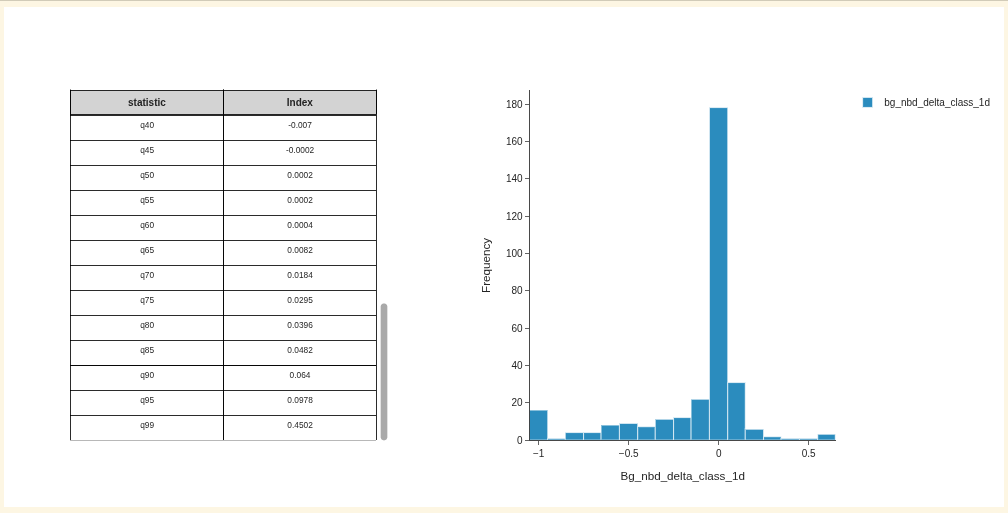
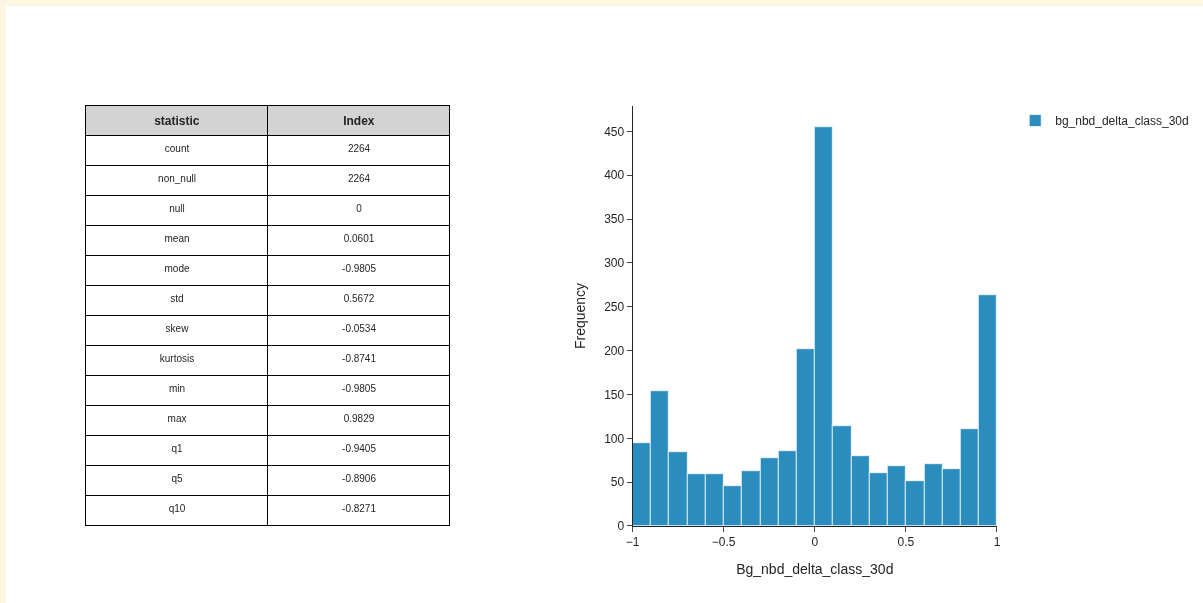
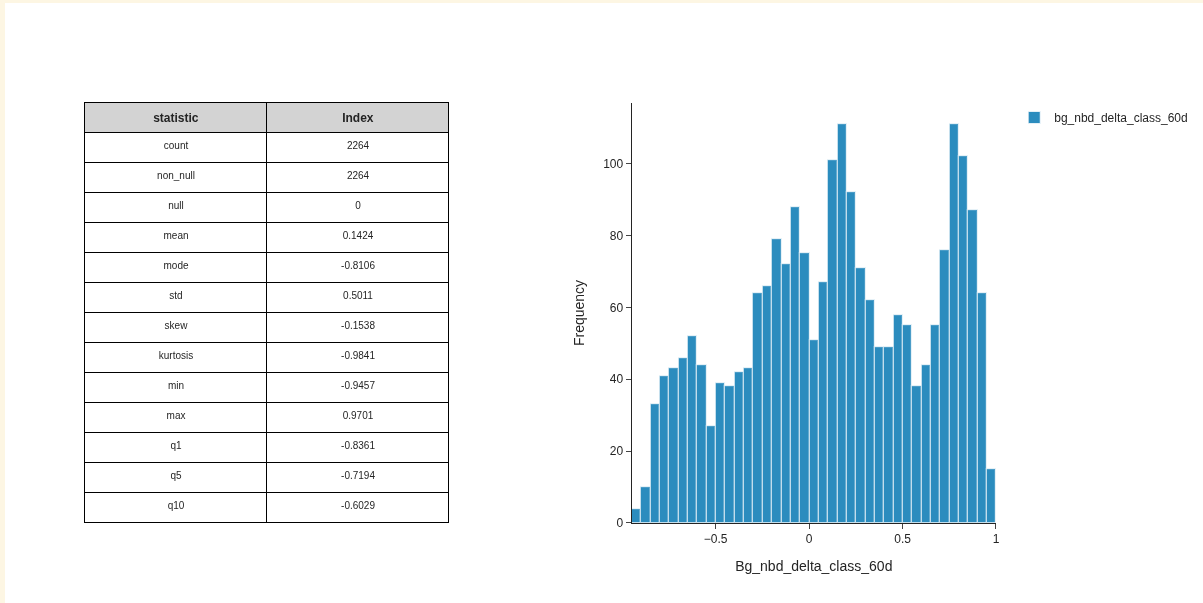
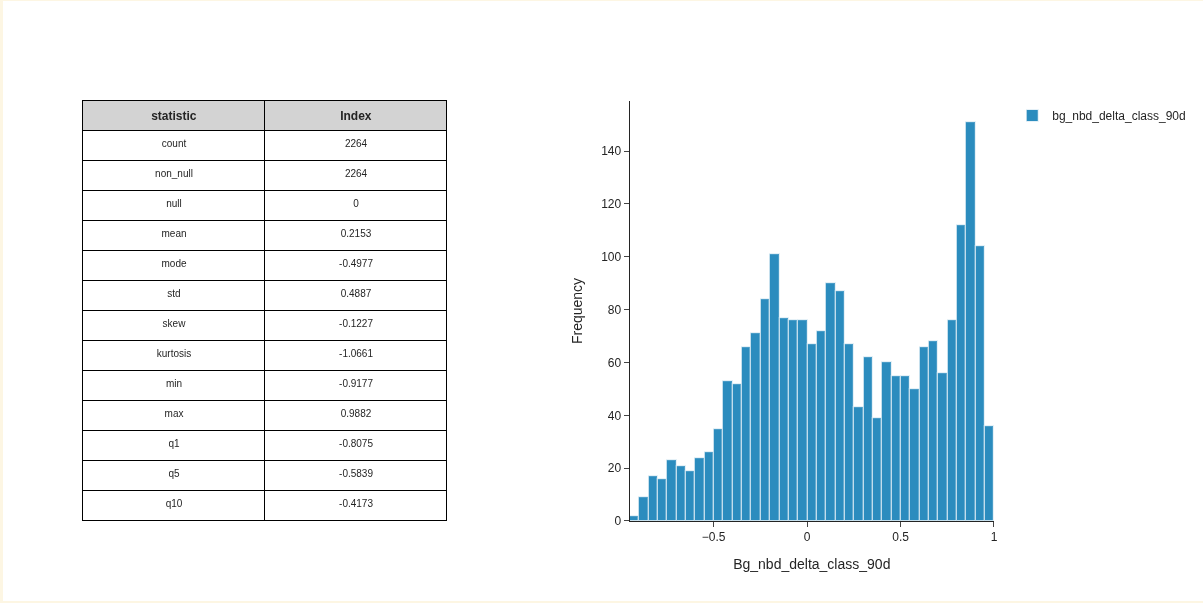

## Target 2: Number of purchases

### Fit Model

For this version, I had to set penalizer_coef=0.05 instead of the previous 0.
Also, 54 customers have values with 0, and I keep seeing this error: "invalid value encountered in log". Hence I only kept the features with values >0

In [567]:
bgf_cut_30d = BetaGeoFitter(penalizer_coef=0.05)
bgf_cut_30d.fit(
    frequency=X_train_cut["frequency"],
    recency=X_train_cut["recency"],
    T=X_train_cut["T"]
)
bgf_cut_30d.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.206712,0.036197,1.135765,1.277659
alpha,7.363792,0.290350,6.794705,7.932878
a,0.183318,0.008509,0.166640,0.199997
b,1.034928,0.047787,0.941267,1.128590


### Predict

In [568]:
for X in (
    X_train_cut,
    X_test_cut,
    X_val_cut
):
    X = predict_n_purchase_bg_nbd(X, bgf_cut_30d, t=30)
    X = predict_p_alive_churn_bg_nbd(X, bgf_cut_30d)

### Evaluate

In [569]:
split_cut_dfs = {
    'train': [X_train_cut, y_train_cut],
    'test': [X_test_cut, y_test_cut],
    'val': [X_val_cut, y_val_cut]
}

In [570]:
results_df = {}
for split in split_cut_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_cut_dfs[split][0][['p_churn']]
    y = split_cut_dfs[split][1][['is_churn']]

    metrics, confusion_matrix_df, eval_df = evaluate_churn_predictions(
        feature_df=X,
        target_df=y
    )

    results_df[split] = [metrics, confusion_matrix_df]

    print(metrics)
    print(confusion_matrix_df)

Evaluation results for train set:
{'roc_auc': 0.9591586827269647, 'pr_auc': 0.96743920341885, 'precision': 0.9523195876288659, 'recall': 0.8138766519823789}
                 pred_no_churn  pred_churn
actual_no_churn            821          37
actual_churn               169         739
Evaluation results for test set:
{'roc_auc': 0.9627485617435726, 'pr_auc': 0.9737508709353973, 'precision': 0.9605734767025089, 'recall': 0.8220858895705522}
                 pred_no_churn  pred_churn
actual_no_churn            246          11
actual_churn                58         268
Evaluation results for val set:
{'roc_auc': 0.967584541062802, 'pr_auc': 0.973520259386512, 'precision': 0.976, 'recall': 0.8133333333333334}
                 pred_no_churn  pred_churn
actual_no_churn            135           3
actual_churn                28         122


Interestingly the model performance with the cut-off data has even better performance than the full data. (Recall 0.80+ vs. 0.75+)

In [571]:
results_df = {}
for split in split_cut_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_cut_dfs[split][0]
    y = split_cut_dfs[split][1]


    mae = (y["n_purchase_30d"] - X["n_purchase"]).abs().mean()

    results_df[split] = mae

    print(mae)

Evaluation results for train set:
1.481239901276825
Evaluation results for test set:
1.4394028760476478
Evaluation results for val set:
1.568637862555286


### Compare Performance with LGBM Regressor

In [572]:
lgbm_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

In [573]:
DROP_COLS = ["n_purchase", "p_alive", "p_churn"]

lgbm_model.fit(
    X_train_cut.drop(columns=DROP_COLS),
    y_train_cut["n_purchase_30d"],
    eval_set=[
        (X_train_cut.drop(columns=DROP_COLS), y_train_cut["n_purchase_30d"]),
        (X_test_cut.drop(columns=DROP_COLS), y_test_cut["n_purchase_30d"]),
        (X_val_cut.drop(columns=DROP_COLS), y_val_cut["n_purchase_30d"]),
    ],
    eval_metric="mae"
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18316
[LightGBM] [Info] Number of data points in the train set: 1766, number of used features: 109
[LightGBM] [Info] Start training from score 2.862401


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [574]:
DROP_COLS = ["n_purchase", "p_alive", "p_churn"]

results_lgbm = {}

for split in split_cut_dfs.keys():

    print(f"Evaluation results for {split} set (LGBM):")

    X = split_cut_dfs[split][0]
    y = split_cut_dfs[split][1]

    y_pred = lgbm_model.predict(
        X.drop(columns=DROP_COLS)
    )

    mae = (y["n_purchase_30d"] - y_pred).abs().mean()

    results_lgbm[split] = mae

    print(mae)

Evaluation results for train set (LGBM):
0.21389091094602594
Evaluation results for test set (LGBM):
1.5908544079667095
Evaluation results for val set (LGBM):
1.8728854950307319


Results for BG/NBD and LGBMRegressor are quite similar, with the former doing generally better on test and val. On the other hand, LGBMRegressor does better on the train set (a sign of overfitting though.)

I actually believe LGBM can get better results with feature transformation and feature selection (I didnt use that version here because of time limitations).

# Productionize

For the use in production, I'm using the model trained on cut-off data.
- n_purchase can be evaluated
- p_alive prediction is good enough compared to the version with all data

## Setup MLflow

In [626]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns/709690053402558735', creation_time=1768715955081, experiment_id='709690053402558735', last_update_time=1768715955081, lifecycle_stage='active', name='bg-nbd', tags={}>

## Write Data

In [ ]:
'''
features_cut_30d = build_cut_30d_features(
    transactions_df=transactions_df,
    customers_df=customers_df,
    n_days=30,
    observed_date=OBSERVED_DATE,
)
'''

In [ ]:
'''
(
    X_train_cut,
    X_val_cut,
    X_test_cut,
    y_train_cut,
    y_val_cut,
    y_test_cut
) = split_train_test_val(
    customers_modeling_df=features_cut_30d,
    targets=['is_churn', 'n_purchase_30d'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)
'''

In [ ]:
'''
split_cut_dfs = {
    'train': [X_train_cut, y_val_cut],
    'test': [X_test_cut, y_test_cut],
    'val': [X_val_cut, y_val_cut]
}
'''

In [ ]:
'''
for split in split_cut_dfs.keys():
    X = split_cut_dfs[split][0]
    y = split_cut_dfs[split][1]
    X.to_csv(BASE_GOLD_DIR / "clv" / f"X_{split}_cut.csv",index="True")
    y.to_csv(BASE_GOLD_DIR / "clv" / f"y_{split}_cut.csv" ,index="True")
'''

## Read Data

In [655]:
inf_split_dfs = {
    'train':[],
    'test':[],
    'val':[]
}

In [656]:
for split in inf_split_dfs.keys():
    X = pd.read_csv(BASE_GOLD_DIR / "clv" / f"X_{split}_cut.csv", index_col=0)
    y = pd.read_csv(BASE_GOLD_DIR / "clv" / f"y_{split}_cut.csv", index_col=0)
    inf_split_dfs[split] = [X, y]

In [658]:
inf_split_dfs['val'][0]

,signup_date,true_lifetime_days,termination_date,frequency,T,recency
customer_id,,,,,,
C02550,2025-06-25,98,2025-10-01,16,155,90
C01354,2025-06-27,56,2025-08-22,8,155,49
C02309,2025-10-22,52,2025-12-13,0,23,0
C02572,2025-05-19,299,2026-03-14,8,174,168
C01480,2025-10-27,219,2026-06-03,11,30,30
...,...,...,...,...,...,...
C01288,2025-07-02,161,2025-12-10,4,132,69
C01021,2025-07-26,305,2026-05-27,2,103,40
C00832,2025-02-06,107,2025-05-24,15,295,97


## Log Model

In [663]:
with mlflow.start_run(
    run_name=f"{BASE_GOLD_DIR}_cut_30d"
):
    mlflow.log_param("gold_data_version", BASE_GOLD_DIR.name)

    train_bg_nbd(
        X_train=inf_split_dfs['train'][0],
        y_train=inf_split_dfs['train'][1],
        X_val=inf_split_dfs['val'][0],
        y_val=inf_split_dfs['val'][1],
        X_test=inf_split_dfs['test'][0],
        y_test=inf_split_dfs['test'][1],
        target_2="n_purchase_30d",
        horizon_days=30,
        threshold=0.5,
    )

## Upgrade model to production

In [664]:
promote_to_production("229b3946b31b48659ad3df3e8e32ab64")

In [678]:
model, metadata = load_prod_bg_nbd()

In [715]:
# Have to also load up the summary dataframe accompanying the model
summary_cut_30d_df = pd.read_csv(BASE_GOLD_DIR / "clv" / "summary_cut_30d_df.csv")

## Inference

In [716]:
predict_users_bg_nbd(
    customer_ids=['C00003'],
    horizon_days=30,
    summary_df=summary_cut_30d_df,
    model=model
)

,p_alive,pred_n_purchase_30d
3,0.8972,1.655735


In [717]:
predict_user_bg_nbd(
    customer_id='C00003',
    horizon_days=30,
    summary_df=summary_cut_30d_df,
    model=model
)

{'customer_id': 'C00003',
 'p_alive': 0.8972,
 'pred_n_purchase_30d': 1.655734941263388}